In [1]:
import lucem_illud_2020 
import networkx as nx
from collections import OrderedDict
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import pandas as pd
import matplotlib.pyplot as plt #For plotting
import seaborn as sns #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics
import zipfile
import sys
import pickle #if you want to save layouts
import os
import sklearn.feature_extraction
import zipfile
from tools import *
from networkx.algorithms.community import greedy_modularity_communities
from lucem_illud_2020.proccessing import normalizeTokens, trainTestSplit, word_tokenize, sent_tokenize

import spacy
nlp = spacy.load('en')
%matplotlib inline

In [2]:
#data = pd.read_csv('heritage_text.csv')
#data.dropna(subset=['text'], inplace=True)
#texts = [clean_data(data, i) for i in range(data.shape[0])]
#data['text'] = texts
#data.to_csv('heritage_text_cleaned.csv', index=False)
data = pd.read_csv('heritage_text_cleaned.csv')
data = data[:100]

In [3]:
data['tokenized_sents'] = data['text'].apply(lambda x: 
            [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x:
                                        [lucem_illud_2020.normalizeTokens(s) for s in x])

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

* I focused on 100 articles from the Heritage Foundation.
* Looking at how documents are connected to each other, it seems that most of the documents are closely connected, but there are a few marginal nodes—those with shorter texts.
* I filtered nodes by weight < 15 and neighbors > 2000.  The two filter methods yield roughly the same graph. There seems to be a big cluster of nodes about terrorism and the Middle East (keywords include Iraq, sanction, war, etc). There are two relatively larger clusters—one focuses on foreign affairs as well but with a more global perspective, and one about domestic politics (tax and constitution). 
* Many of the top 15 cliques mention the Heritage Foundation itself. This suggests a self-advertising behavior. The other cliques are all about Iran and U.S. national security. 
* I rendered the graphs with 1 and 2 network steps of 'Trump.' With 1 step, the nodes focus primarily on “Donald the president” and “the U.S.-Iran Deal..” The 2 network steps graph provides much more complicated information. In addition to the topics about Iran, it shows that "Trump" is also closely related to topics about China's human right problems, the Christian identity, and other national security issues.

In [4]:
Vectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
Vects_incidence = Vectorizer.fit_transform(data['text'])

In [5]:
g_2mode = nx.Graph()
g_2mode.add_nodes_from((Vectorizer.get_feature_names()[i] for i in range(Vects_incidence.shape[1])), 
                        bipartite = 'word')
g_2mode.add_nodes_from(range(Vects_incidence.shape[0]), bipartite = 'doc')
g_2mode.add_edges_from(((d, Vectorizer.get_feature_names()[w], 
                         {'weight' : Vects_incidence[d, w]}) for d, w in zip(*Vects_incidence.nonzero())))

In [6]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 7874
Number of edges: 30381
Average degree:   7.7168


In [7]:
print(Vects_incidence.shape)
print(nx.info(g_2mode))
gDoc = contractNetwork(g_2mode, 'doc')
print(nx.info(gDoc))
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

(99, 7775)
Name: 
Type: Graph
Number of nodes: 7874
Number of edges: 30381
Average degree:   7.7168
Name: 
Type: Graph
Number of nodes: 99
Number of edges: 4839
Average degree:  97.7576
Name: 
Type: Graph
Number of nodes: 7775
Number of edges: 4009867
Average degree: 1031.4770


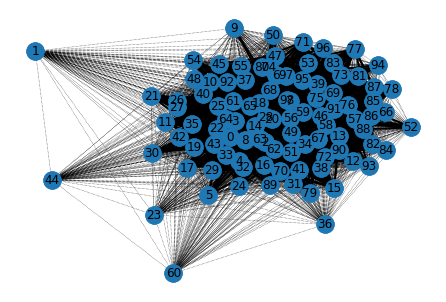

In [8]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()},
        edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [9]:
print([len(i) for i in data['text'][[1, 60, 44, 23, 36]]])
data['text'][[1, 60, 44, 23, 36]]

[425, 397, 405, 791, 1045]


1     Thousands of pro-lifers move down the streets ...
60    San Francisco has been called the Paris of the...
44    Pro-democracy protests in Hong Kong are intens...
23    It's possible for people with different politi...
36    Protesters cover up their right eye in honor o...
Name: text, dtype: object

In [10]:
print([len(i) for i in data['text'][[58, 51, 88]]])
data['text'][[58, 51, 88]]

[8129, 10171, 5260]


58    Iran’s Islamist dictatorship has been challeng...
51    This article s adapted from a lecture James Ca...
88    Saudi Crown Prince Mohammed bin Salman, right,...
Name: text, dtype: object

### Filtered by Weight and Neighbors 

In [11]:
g = wordCooccurrence(data['normalized_sents'].sum())

In [12]:
remove_edges = [(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 15]
g.remove_edges_from(remove_edges)
g.remove_nodes_from(list(nx.isolates(g))) 
giant = max(connected_component_subgraphs(g), key=len)
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 126
Number of edges: 254
Average degree:   4.0317


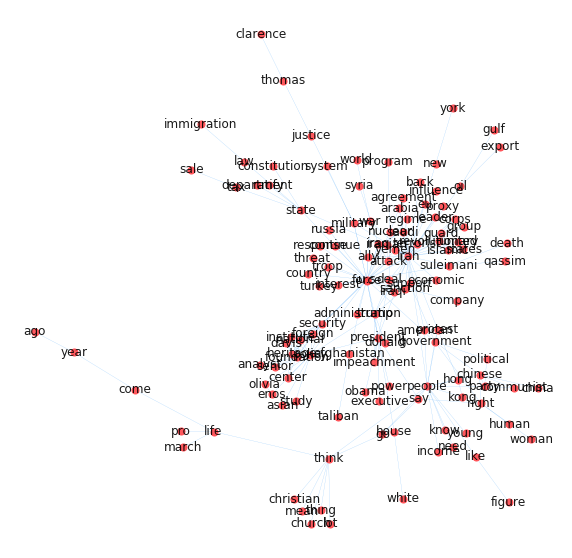

In [13]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, 
        labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 50,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [14]:
#c = list(greedy_modularity_communities(giant))
giant = nx.Graph(giant)
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 126
Number of edges: 254
Average degree:   4.0317


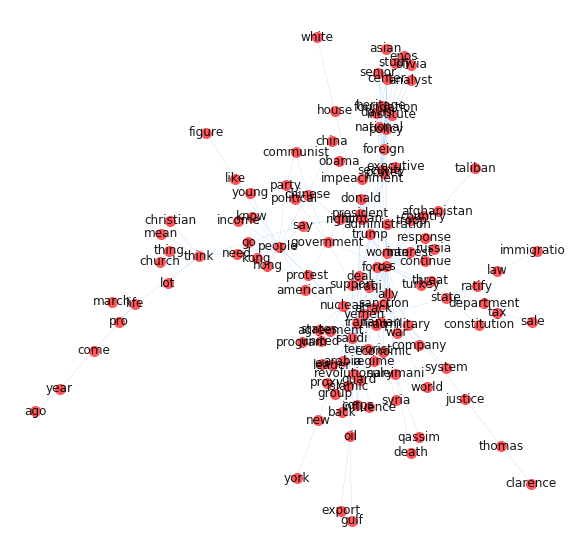

In [15]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

### Finding Cliques

In [16]:
cliques = list(nx.clique.find_cliques(giant))
cliques = sorted(cliques, key = lambda x: len(x))
for i in range(15):
    print('Clique',i+1, ','.join(cliques[-(1+i)]))

Clique 1 institute,foundation,security,policy,foreign,davis,national,heritage
Clique 2 iran,u.s,iranian,iraq,attack
Clique 3 iran,u.s,force,iraq,attack
Clique 4 iran,u.s,deal,trump,president
Clique 5 policy,u.s,trump,president
Clique 6 policy,u.s,foreign,security
Clique 7 heritage,foundation,policy,senior
Clique 8 center,foundation,heritage,policy
Clique 9 iran,u.s,war,military
Clique 10 iran,u.s,sanction,trump
Clique 11 iran,u.s,force,president
Clique 12 iran,u.s,force,military
Clique 13 iran,u.s,nuclear,deal
Clique 14 iran,guard,corps,revolutionary
Clique 15 iran,islamic,revolutionary,guard


Name: 
Type: Graph
Number of nodes: 9
Number of edges: 19
Average degree:   4.2222


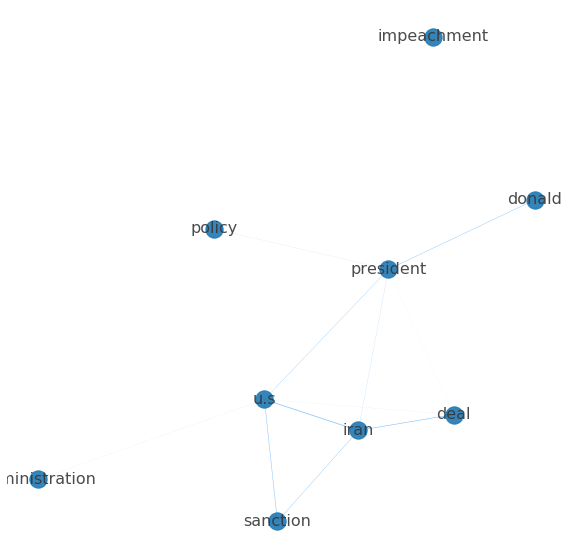

In [17]:
# 1 network steps of 'Trump'
trumpNeighbors = giant.neighbors('trump')
g_trump = giant.subgraph(trumpNeighbors)
print(nx.info(g_trump))

layout_amer = nx.spring_layout(g_trump, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_trump.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_trump.edges(data = True)))
nx.draw(g_trump, ax = ax, pos = layout_amer, 
        labels = {n:n for n in g_trump.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in 
               g_trump.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

Name: 
Type: Graph
Number of nodes: 123
Number of edges: 243
Average degree:   3.9512


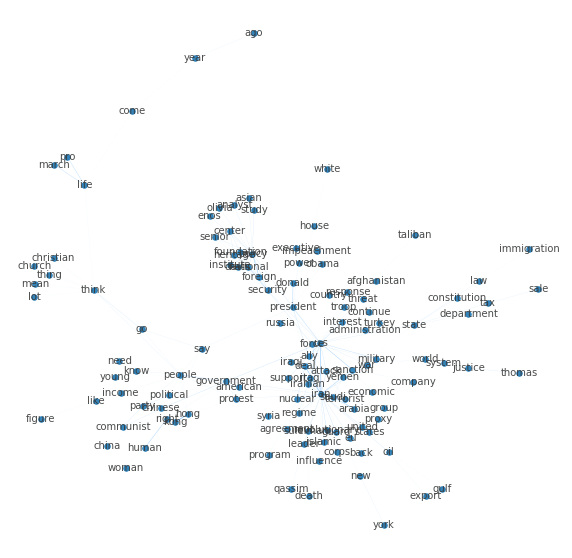

In [18]:
# 2 network steps of 'Trump'
trumpNeighbors = gWord.neighbors('trump')
trumpNeighborsPlus1 = set(trumpNeighbors)
for n in trumpNeighbors:
    trumpNeighborsPlus1 |= set(giant.neighbors(n))
g_trump2 = giant.subgraph(trumpNeighborsPlus1)
print(nx.info(g_trump2))

layout_amer = nx.spring_layout(g_trump2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_trump2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_trump2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_trump2.edges(data = True)))

nx.draw(g_trump2, ax = ax, pos = layout_amer,
        node_size = 30,
        labels = {n:n for n in g_trump2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in 
               g_trump2.edges(data = True)], 
        alpha = .9, 
        font_size = 10,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

* **Global Measure**:The density of the network (the ratio of the number of edges to the number of possible edges in a network with nodes) is about 0.03, the average degree per node is about 4.03, and the maximum distance between nodes is 10. The low ratio between "actual edges" and "potential edges" as well as the relatively low average degree per node suggests that our articles are highly topic specific--words in different topics do not appear together and therefore are not likely to be connected.
* **Degree Centrality**: Iran and U.S. are the most central nodes—even more than “president” and “heritage foundation.“ The words such as “attack” and “iraq” again confirm the corpus’ exhausted focus on the Middle East.
* **Betweenness Centrality**: while “Iran“, “US”, “policy,” and “people,” the nodes with high degree centrality maintain in the top 10 list, the word “foundation“ (the Heritage Foundation) disappear from the top 10 betweenness centrality list. This suggests that “foundation” are not often related to other words, but because they are often mentioned together with the word “Heritage”, they boost each other’s degree centrality. Betweenness Centrality, instead, calculates how a node connects other pairs of nodes. Words such as “president” and “people,” which are associated with almost all topics, therefore have high betweenness centrality.
* **Eigenvector Centrality**: “Iran“, “US” are still the top two words. It is interesting to see that the word “attack” has high eigenvector centrality now but is not among the top10 nodes with the highest degree centrality or betweenness centrality. This is because the word “attack” connects the hottest words “Iran” and “US,” and is thus considered highly influential in the network.

In [19]:
print(nx.density(giant))
print(np.mean([v for w,v in nx.degree(giant)]))
print(nx.diameter(giant))

0.03225396825396826
4.031746031746032
10


### Degree Centrality

In [20]:
dcentralities = nx.degree_centrality(giant)
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('iran', 0.34400000000000003),
 ('u.s', 0.272),
 ('policy', 0.152),
 ('people', 0.14400000000000002),
 ('president', 0.12),
 ('think', 0.08),
 ('state', 0.07200000000000001),
 ('trump', 0.07200000000000001),
 ('foundation', 0.07200000000000001),
 ('security', 0.07200000000000001)]

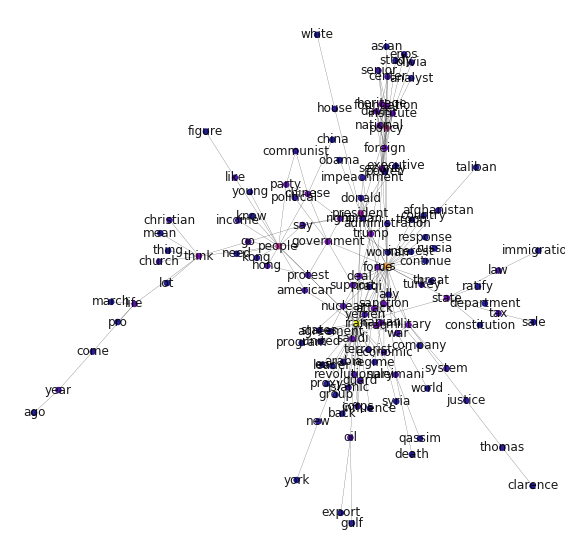

In [21]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, alpha = .9, node_size = 30,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

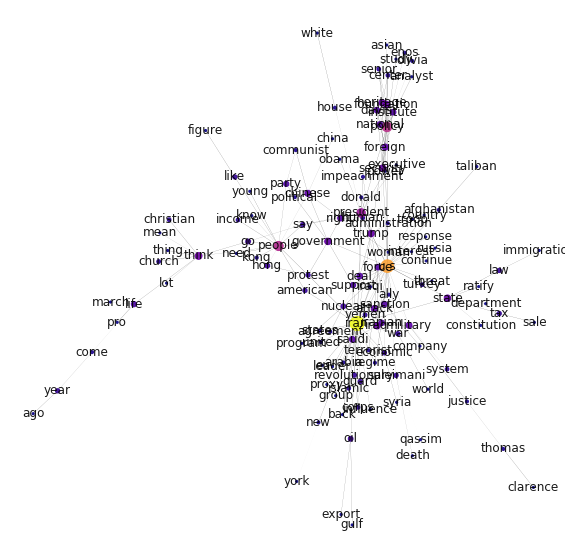

In [22]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in 
               gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

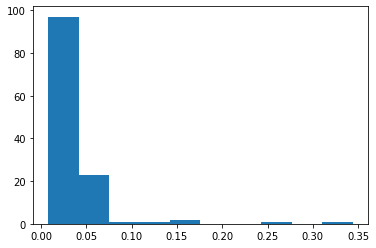

In [23]:
plt.hist(list(dcentralities.values()))
plt.show()

### Betweenness Centrality

In [24]:
centralities = nx.betweenness.betweenness_centrality(giant)
print(centralities['trump'])
print(max(centralities.items(), key = lambda x : x[1]))
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

0.03613890273092311
('iran', 0.538541199283644)


[('iran', 0.538541199283644),
 ('u.s', 0.3556833395806233),
 ('people', 0.31859078977992383),
 ('think', 0.1669677419354839),
 ('policy', 0.14274084220815975),
 ('president', 0.13526222925348555),
 ('state', 0.10903225806451614),
 ('government', 0.09157694884817126),
 ('life', 0.07832258064516129),
 ('military', 0.0629247311827957)]

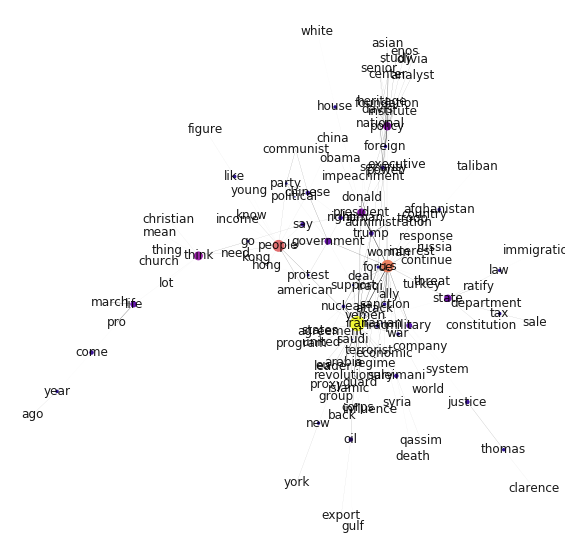

In [25]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in 
               giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

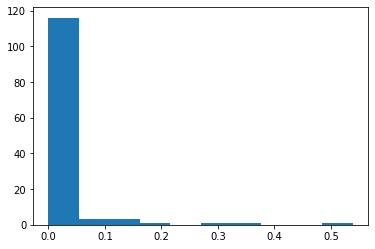

In [26]:
plt.hist(list(centralities.values()))
plt.show()

### Eigenvector Centrality

In [27]:
centralities = nx.eigenvector_centrality(giant)
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('iran', 0.47841388199629403),
 ('u.s', 0.4335499884275421),
 ('president', 0.20629770668321346),
 ('policy', 0.18794750996900278),
 ('trump', 0.17781862598156886),
 ('force', 0.1772633129272896),
 ('iraq', 0.17430338494608302),
 ('attack', 0.16828026624539685),
 ('deal', 0.160716619020335),
 ('iranian', 0.14998695788164568)]

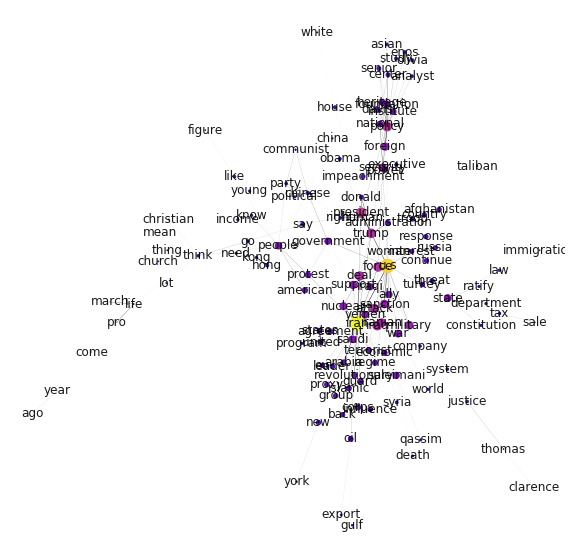

In [28]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

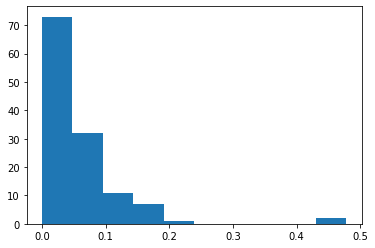

In [29]:
plt.hist(list(centralities.values()))
plt.show()

### Filtered graph

In [30]:
giant_filtered = filterWords(giant, minWeight=3, filter_='betweenness', 
                               rule='number', value_of_rule=40)
print(nx.info(giant_filtered))

Total number of nodes(after filtering) in the graph is 40
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 108
Average degree:   5.4000


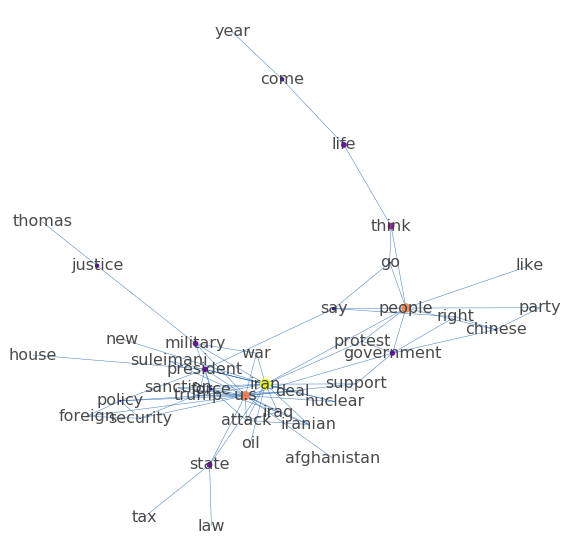

In [31]:
layout_giant_filtered = nx.spring_layout(giant_filtered, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant = nx.betweenness_centrality(giant_filtered)
maxC = max(centralities_giant.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered, ax = ax, pos = layout_giant_filtered, 
        labels = {n: n for n in giant_filtered.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant[n] / maxC for n in giant_filtered.nodes],
        node_size = [centralities_giant[n] / maxC * 100 for n in giant_filtered.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

* In the following cells, I generated three networks (NN-NN, NN-VB, NN-JJ)
* The NN-NN network does not have a strong pattern of clusters. But words like "government," "country," "year," and "time" have the highest eigenvector centrality because they are important in narratives of all topics: it is always "a government of a country does something in certain year at certain time." 
* The NN-VB network does not have a strong pattern of clusters as well. But it seems that it is mostly about government, student, country that are doing or influenced by something.
* The NN-JJ network does not have a strong pattern of clusters as well. In addition to some common words, the adjectives in this graph are "military," "political," and "religious,” mostly used to discribe the government, system, and country, suggesting a sense of conservative ideology.
* I also graphed "ego-networks" centered around the word "trump" with words 1/2/3 links away. The 2-step graph is probably the most interesting one. It seems that Trump is always claiming, trying or coming to something/ someplace.

In [32]:
gNN = posCooccurrence(data['normalized_sents'].sum(), 'NN')
gNV = posCooccurrence(data['normalized_sents'].sum(), 'NN', 'VB')
gNJ = posCooccurrence(data['normalized_sents'].sum(), 'NN', 'JJ')

In [33]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 110]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 85
Number of edges: 1771
Average degree:  41.6706


In [34]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if 
                       gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 1])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 3])
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 195
Number of edges: 801
Average degree:   8.2154


In [35]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', 
                              value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 161
Average degree:  12.8800


### Nouns - Nouns

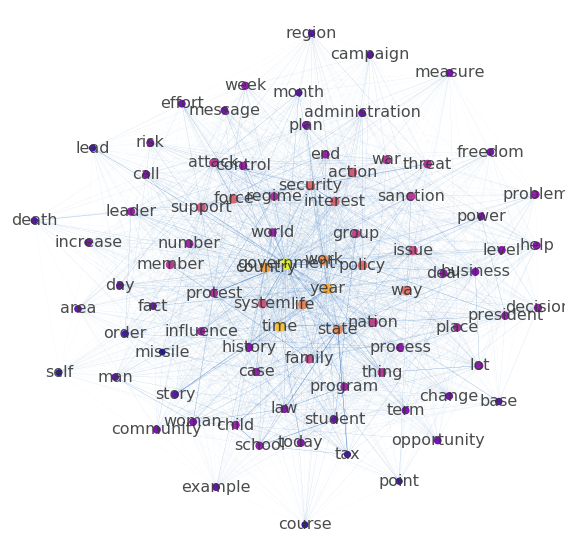

In [36]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d 
               in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

### Nouns - Verbs

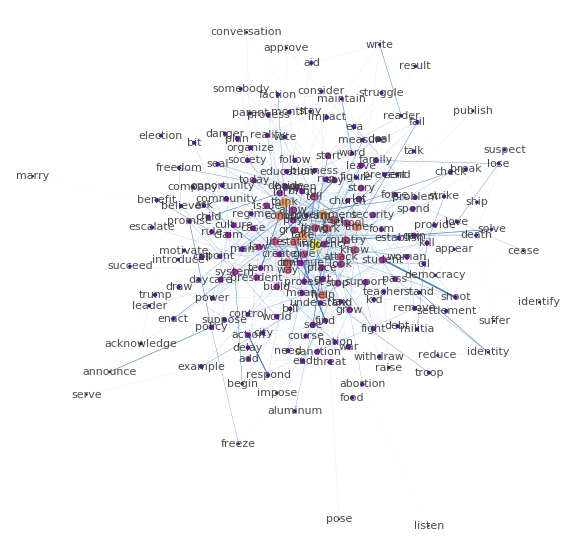

In [70]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in 
               gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 11,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

### Nouns - Adjectives

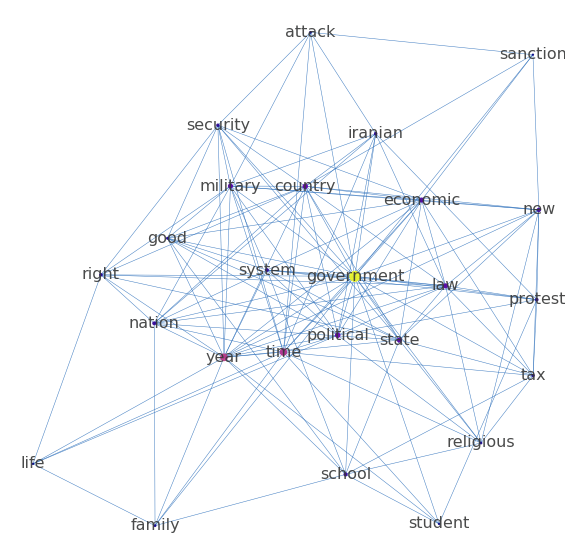

In [38]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

### Ego-Network (3 steps)

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 4
Average degree:   1.6000


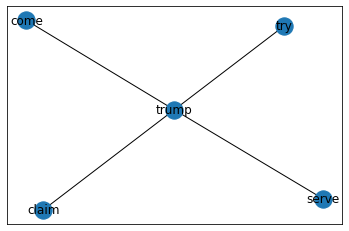

In [80]:
### 1 step
g_i = gNV.subgraph(['trump'] + list(gNV.neighbors('trump')))
print(nx.info(g_i))
nx.draw_networkx(g_i)

In [81]:
# 2 steps
storyNeighbors = set(gNV.neighbors('trump'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 49
Number of edges: 69
Average degree:   2.8163


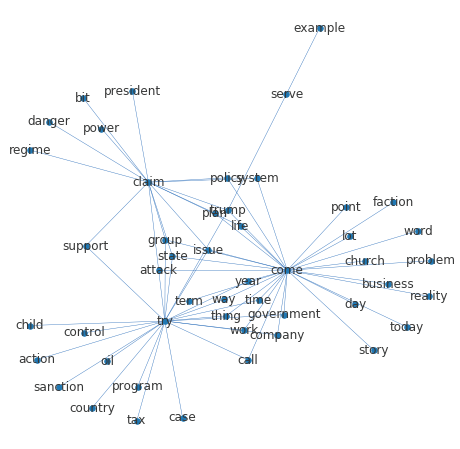

In [82]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (8,8))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 12,node_size = 30,
        width = 0.4,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue') 

In [83]:
# 3 steps
storyNeighborsPlus2 = set(storyNeighborsPlus1)
for n in storyNeighborsPlus1:
    storyNeighborsPlus2 |= set(gNV.neighbors(n))
gNV_story = gNV.subgraph(storyNeighborsPlus2)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 128
Number of edges: 459
Average degree:   7.1719


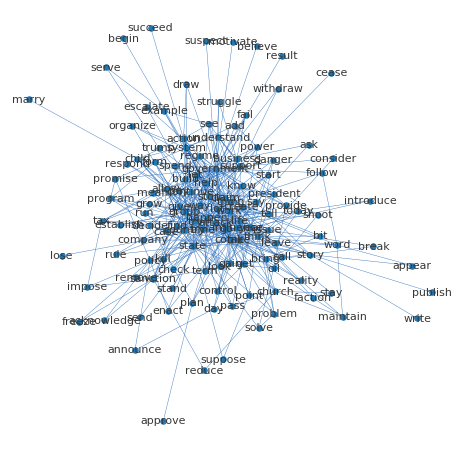

In [84]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (8,8))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 11,node_size = 30,
        width = 0.4,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue') 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

* Also to save time I simply ran the code in the original notebook and generated soup_df.csv with all words already tokenized. Here I simply reloaded it and re-formatted it.
* Because my corpus does not have actor-specific information (maybe I will have it later), I focus on another soup opera called *Bold and Beautiful* and analyze the actors who appears over 1000 times as interacting with others.
* As shown in the heat map and the network graph, most of the interactions happen between Brooke and Ridge and they are also at the center of other person’s social interaction. This makes sense because Ridge and Brooke have been married for over twenty years and are the main characters in this opera. They are at the center also because they are the parents of the rest of the important characters: Rick, Bridget, Hope, R.J. and Jack.
* The second heat map uses KS method to show whether the actors have similar tones. In general, they seems to have quite different tones. Although Brooke and Ridge have quite frequent interactions, they do not tend to have more similar tones--probably because they are opposite sex and the whole opera is about how they have complicated erotic relationship with other people.

In [44]:
soap_df = pd.read_csv('soup_df.csv')
soap_df.head()

,Soap Name,Tokenized Texts
0,All My Childen,"['@!Reporter', 'Is', 'there', 'anything', 'you..."
1,As the World Turns,"['@!Katie', 'Okay', 'I', 'know', 'these', 'wor..."
2,Bold and Beautiful,"['@!Bridget', 'What', 'did', 'you', 'say', '@!..."
3,Days of Our Lives,"['@!Maggie', 'How', 'are', 'you', 'doing', '@!..."
4,General Hospital,"['@!Luke', 'I', 'signed', 'my', 'divorce', 'pa..."


In [45]:
## Bold and Beautiful
dool = soap_df['Tokenized Texts'][2].strip('[').strip(']').split(', ')
dool = [i.strip('\'').strip('\"') for i in dool]
' '.join(dool[0:150])

"@!Bridget What did you say @!Deacon Just forget I said it @!Bridget You want to get married @!Amber Oh how did I ever let Deacon talk me into this @(Amber sighs @!Amber How am I gon na explain it to Rick I 'm not not today The last thing he needs to hear on his wedding day is that Deacon and I have matching tattoos @(Door opens @!Rick Eric 's with Helen He 's doin great Wow @!Amber You like @!Rick What did I ever do to deserve this @!Amber You married me @!Rick Brilliant idea @!Amber You still think so after what happened today @!Rick God can you believe Bridget She 's always been so sensible How could she get mixed up with a loser like Deacon @(Amber sighs @!Amber I do n't know Deacon 's pretty persuasive @!Rick Yeah well at least we put an end to it"

In [46]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1
len(characters)

613

In [47]:
actor_network = nx.Graph()
for character in characters:
    if characters[character] > 1000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])
print(len(actor_network.nodes.data()))
actor_network.nodes.data()

14


NodeDataView({'Bridget': {'lines_spoken': 2181, 'words': []}, 'Rick': {'lines_spoken': 1516, 'words': []}, 'Brooke': {'lines_spoken': 4706, 'words': []}, 'Eric': {'lines_spoken': 1902, 'words': []}, 'Stephanie': {'lines_spoken': 3098, 'words': []}, 'Ridge': {'lines_spoken': 3314, 'words': []}, 'Jackie': {'lines_spoken': 1259, 'words': []}, 'Taylor': {'lines_spoken': 1688, 'words': []}, 'Steffy': {'lines_spoken': 1201, 'words': []}, 'Nick': {'lines_spoken': 2651, 'words': []}, 'Hope': {'lines_spoken': 1132, 'words': []}, 'Donna': {'lines_spoken': 1085, 'words': []}, 'Katie': {'lines_spoken': 1143, 'words': []}, 'Sighs': {'lines_spoken': 1634, 'words': []}})

In [48]:
i = 0
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

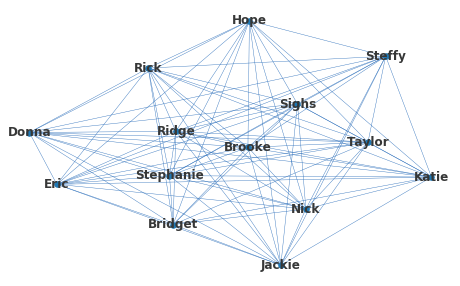

In [49]:
layout_actor = nx.spring_layout(actor_network, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (8,5))
nx.draw(actor_network, ax = ax, pos = layout_actor, 
        with_labels=True, font_weight='bold',
        node_size = 30, width = 0.4,
        font_color = 'xkcd:dark grey', edge_color = 'xkcd:medium blue')

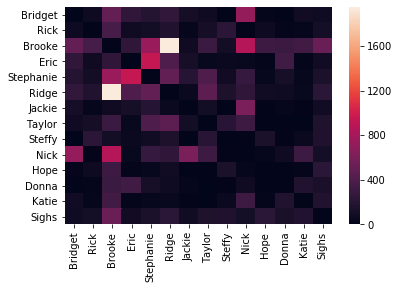

In [50]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            try: l.append(actor_network.edges[(node, node_)]['weight'])
            except KeyError: l.append(0)
    L.append(l)
    
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), 
                       index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [51]:
print(list(greedy_modularity_communities(actor_network)))

[frozenset({'Bridget', 'Nick', 'Brooke', 'Stephanie', 'Taylor', 'Donna', 'Katie', 'Rick', 'Ridge', 'Jackie', 'Steffy', 'Sighs', 'Eric', 'Hope'})]


In [52]:
smaller_actor_network = nx.Graph()
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1:
            try: weight = actor_network.edges[(actor_1, actor_2)]['weight']
            except KeyError: weight = 0
        else: weight = 0
        if weight > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=weight)

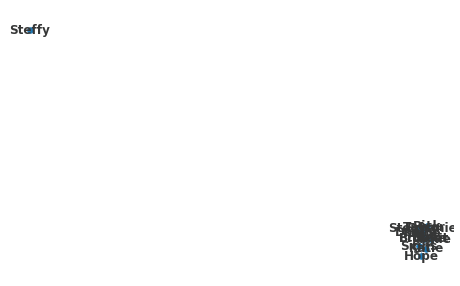

In [53]:
layout_actor = nx.spring_layout(smaller_actor_network, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (8,5))
nx.draw(smaller_actor_network, ax = ax, pos = layout_actor, 
        with_labels=True, font_weight='bold',
        node_size = 30, width = 0.4,
        font_color = 'xkcd:dark grey', edge_color = 'xkcd:medium blue')
### Steffy is such an outsider that we want to remove this person

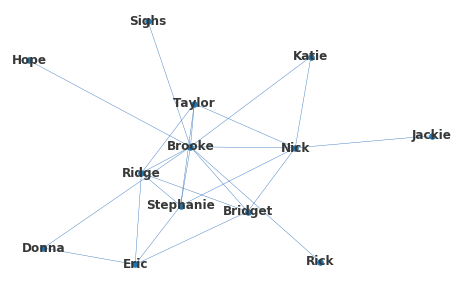

In [54]:
smaller_actor_network.remove_nodes_from(['Steffy'])
layout_actor = nx.spring_layout(smaller_actor_network, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (8,5))
nx.draw(smaller_actor_network, ax = ax, pos = layout_actor, 
        with_labels=True, font_weight='bold',
        node_size = 30, width = 0.4,
        font_color = 'xkcd:dark grey', edge_color = 'xkcd:medium blue')

In [55]:
dcentralities = nx.degree_centrality(smaller_actor_network)
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('Brooke', 0.8333333333333333),
 ('Nick', 0.5),
 ('Ridge', 0.41666666666666663),
 ('Stephanie', 0.41666666666666663),
 ('Bridget', 0.3333333333333333),
 ('Eric', 0.3333333333333333),
 ('Taylor', 0.3333333333333333),
 ('Donna', 0.16666666666666666),
 ('Katie', 0.16666666666666666),
 ('Rick', 0.08333333333333333)]

In [56]:
dcentralities = nx.betweenness_centrality(smaller_actor_network)
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('Brooke', 0.6022727272727273),
 ('Nick', 0.2032828282828283),
 ('Stephanie', 0.050505050505050504),
 ('Bridget', 0.04292929292929293),
 ('Ridge', 0.03409090909090909),
 ('Eric', 0.026515151515151516),
 ('Donna', 0.017676767676767676),
 ('Taylor', 0.007575757575757576),
 ('Rick', 0.0),
 ('Hope', 0.0)]

In [57]:
dcentralities = nx.eigenvector_centrality(smaller_actor_network)
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('Brooke', 0.49211614504347),
 ('Stephanie', 0.37280513283876726),
 ('Nick', 0.36372388401783673),
 ('Ridge', 0.36258590805005636),
 ('Taylor', 0.33024472097008745),
 ('Bridget', 0.3042659841964253),
 ('Eric', 0.2476331776921459),
 ('Katie', 0.17762197705782595),
 ('Donna', 0.1535274762141398),
 ('Rick', 0.10213426718382934)]

In [58]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [59]:
L = []
for p in corpora:
    l = [Divergence(p,q, difference='KS') for q in corpora]
    L.append(l)
M = np.array(L)

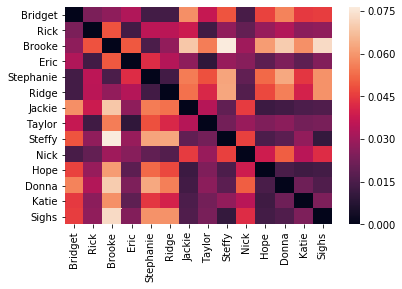

In [60]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [61]:
np.corrcoef(M_, M)[0]

array([ 1.        ,  0.23508783,  0.25867983,  0.02677701,  0.4844077 ,
        0.47415568,  0.79546196,  0.55339289, -0.14085425,  0.09516251,
        0.26492649,  0.49133752,  0.69302407,  0.3708098 , -0.40957406,
        0.15309448, -0.61643184,  0.27672237, -0.52862706, -0.50494939,
        0.50122953,  0.34989289,  0.60193744, -0.61337064,  0.53653615,
        0.57436629,  0.45011666,  0.58188673])

In [64]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,Bush,"[ekfd, cldf, jjsi, asjj, lldi, scgf, kcaj, cbd...",0.507534,1.675050
1,Roosevelt,"[gieg, gkgl, jkch, dkga, cdsb, sfhl, chgd, sef...",2.382005,3.557791


In [66]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud_2020.make_TalkbankXML(df_transcript, output_fname, language = language)
Vocab_size = 500 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud_2020.bec_run(output_fname, Vocab_size, language, sampling_time)

New File saved to ./data/USpresident/USpresident.xml
